In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import pandas as pd
import seaborn as sns

from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from scipy.stats import pearsonr

In [2]:
pca_df = pd.read_pickle("../../../../data/test_correlation/PCA/PCA.pkl")

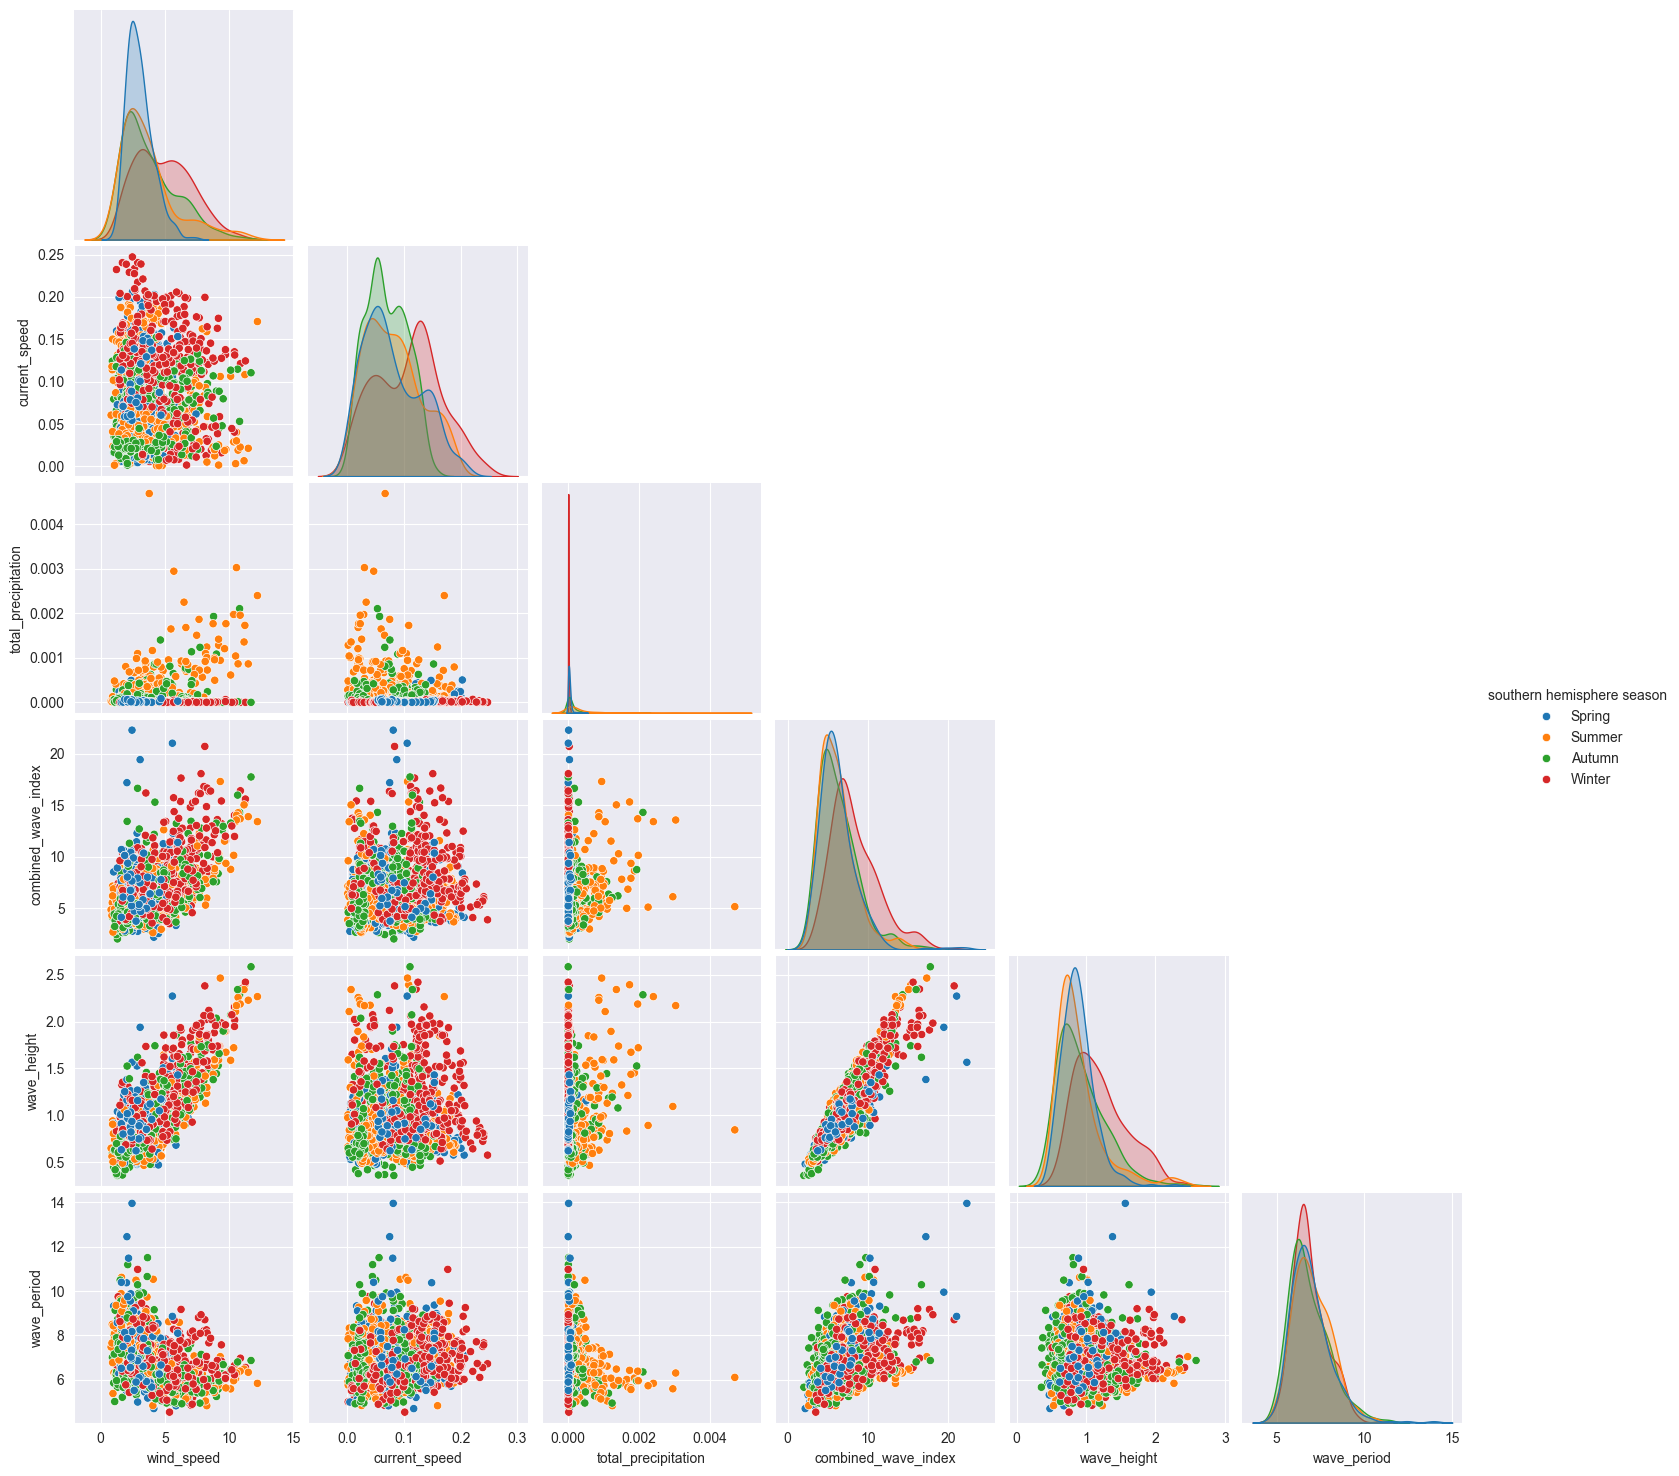

In [3]:
# Ajouter un target de saison
def southern_hemisphere_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

pca_df["southern hemisphere season"] = pca_df.index.map(southern_hemisphere_season)

sns.pairplot(pca_df, hue="southern hemisphere season", corner=True)
plt.show()

In [4]:
# # Visualisation 3D
#
# X = pca_df.drop(columns=["southern hemisphere season"])
# y = pca_df["southern hemisphere season"]
#
# # Standardisation
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
#
# # Reduct PCA dimentions
# X_reduced = PCA(n_components=3).fit_transform(X_scaled)
#
# # Create 3D plot
# fig = plt.figure(1, figsize=(10,7))
# ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
#
# seasons_to_int = {s: i for i, s in enumerate(sorted(labels.unique()))}
# colors = y.map(seasons_to_int)
#
# scatter = ax.scatter(
#     X_reduced[:, 0],
#     X_reduced[:, 1],
#     X_reduced[:, 2],
#     c=colors,
#     s=40,
#     cmap="viridis",
# )
#
# # Ticks and title
# ax.set(
#     title="Principal component analysis (PCA)",
#     xlabel="Principal component 1",
#     ylabel="Principal component 2",
#     zlabel="Principal component 3",
# )
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# ax.zaxis.set_ticklabels([])
#
# # Legend
# handles, _ = scatter.legend_elements()
# season_names = [s for s, i in sorted(seasons_to_int.items(), key=lambda x: x[1])]
# legend1 = ax.legend(handles, season_names, loc="upper right", title="Season")
# ax.add_artist(legend1)
#
# plt.show()

In [5]:
# Standardisation
X = pca_df.drop(columns=["southern hemisphere season"])
y = pca_df["southern hemisphere season"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

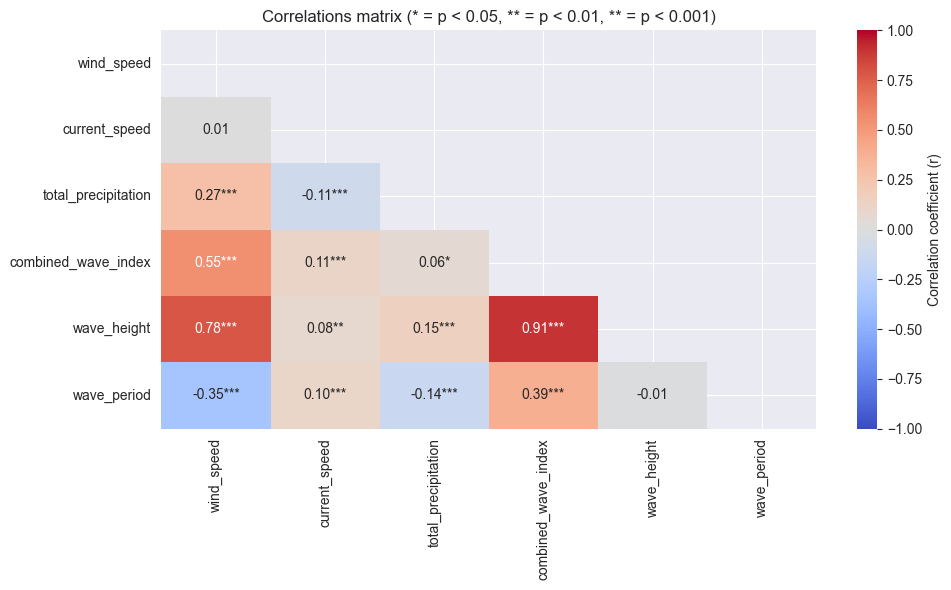

In [6]:
# Correlations matrix with p-values
corr_matrix =  X.corr()
pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape), columns=X.columns, index=X.columns)
annot_matrix = corr_matrix.copy().astype(str)

# Calculate p-values
for row in X.corr():
    for col in X.columns:
        if row != col:
            r, p = pearsonr(X[row], X[col])
            corr_matrix.loc[row,col] = r
            pval_matrix.loc[row,col] = p
            if p < 0.001:
                star = "***"
            elif p < 0.01:
                star = "**"
            elif p < 0.05:
                star = "*"
            else:
                star = ""
            annot_matrix.loc[row,col] = f"{r:.2f}{star}"
        else:
            annot_matrix.loc[row,col] = "" # Umpty diagonal for perfect self-correlation

# Plot matrix with significant correlations
plt.figure(figsize=(10,6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Keeps half of the matrix

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            cbar_kws={"label":"Correlation coefficient (r)"}
)

plt.title("Correlations matrix (* = p < 0.05, ** = p < 0.01, ** = p < 0.001)")
plt.tight_layout()
plt.show()

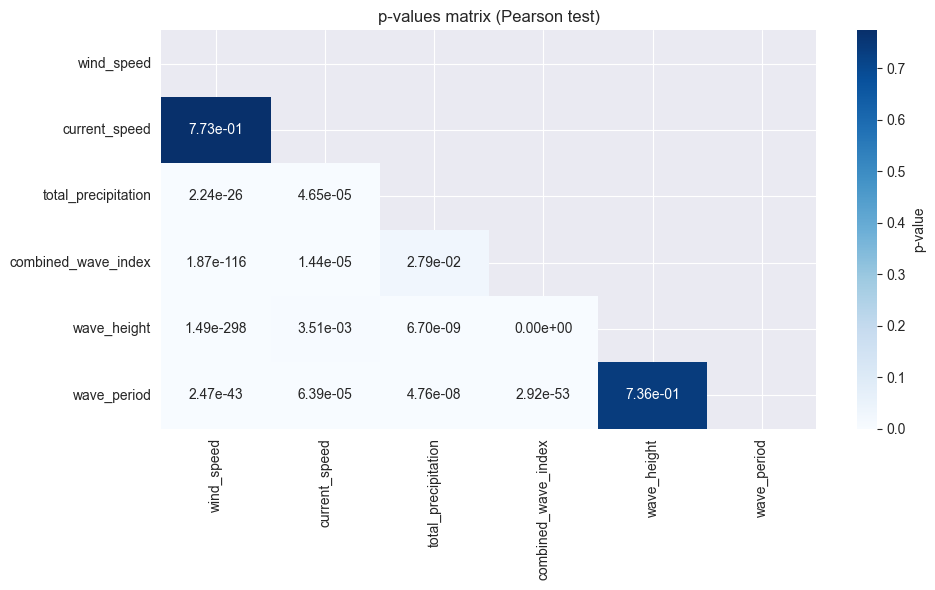

In [7]:
# p-values matrix (optional)
plt.figure(figsize=(10,6))
sns.heatmap(pval_matrix, mask=mask, annot=True, fmt=".2e", cmap="Blues", cbar_kws={"label":"p-value"})
plt.title("p-values matrix (Pearson test)")
plt.tight_layout()
plt.show()

In [8]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Cumulative explained variance: [0.42620403 0.67107257 0.83216824 0.97051417 0.99829939 1.        ]


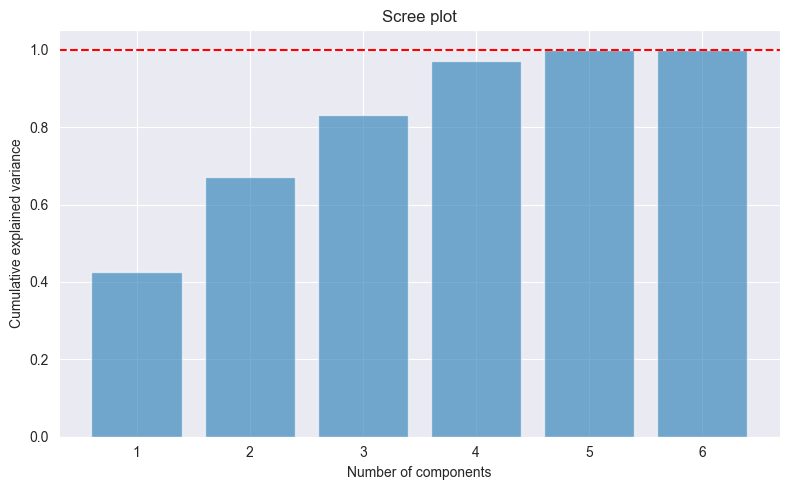

In [9]:
# Scree plot
eigenvalues = pca.explained_variance_ratio_

print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))


plt.figure(figsize=(8,5))
plt.bar(range(1, len(eigenvalues) + 1), np.cumsum(eigenvalues), alpha=0.6)
plt.axhline(y=1.0, color='red', linestyle='--', label="kaiser criterion")


plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Scree plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Contribution and representation quality
components = pca.components_ # eigenvectors
explained = pca.explained_variance_ratio_ * 100

contrib = pd.DataFrame(
    components**2,
    columns=X.columns,
    index = [f"PC{i+1}" for i in range(len(components))]
).T * 100

print("\n--- Contribution des variables (%) ---")
print(contrib.round(2))


--- Contribution des variables (%) ---
                       PC1    PC2    PC3    PC4    PC5    PC6
wind_speed           28.47   9.44   2.47   1.59  57.64   0.39
current_speed         0.38  11.35  66.49  21.78   0.00   0.00
total_precipitation   2.88  17.47   9.94  68.96   0.74   0.01
combined_wave_index  30.95  11.23   2.45   0.18   8.19  47.00
wave_height          37.32   0.17   0.02   1.68  14.54  46.27
wave_period           0.00  50.34  18.63   5.80  18.90   6.33


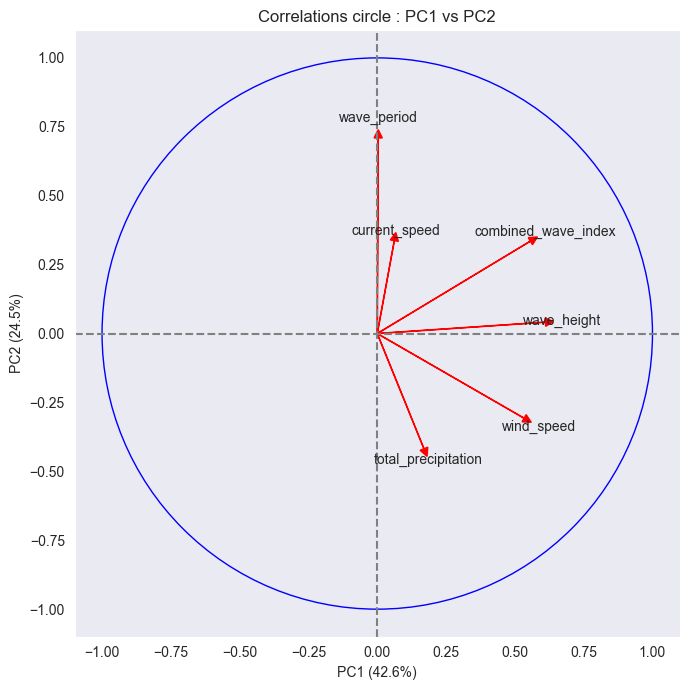

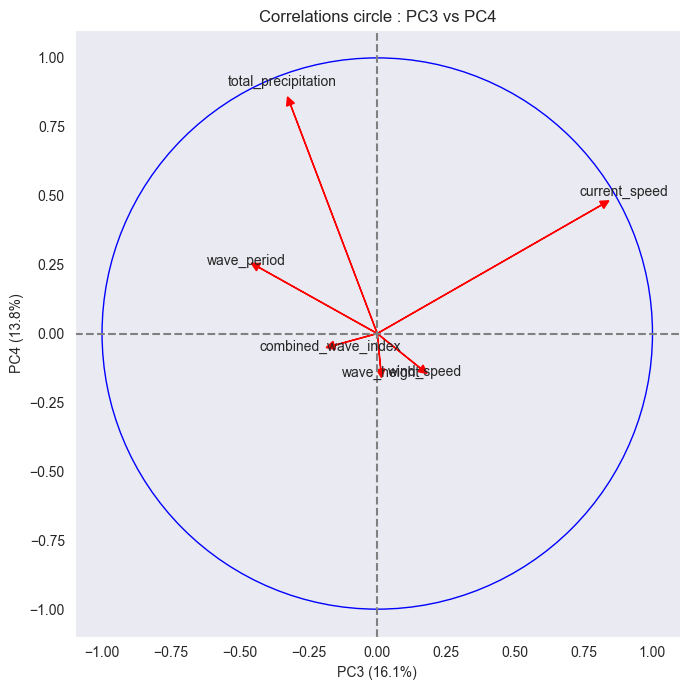

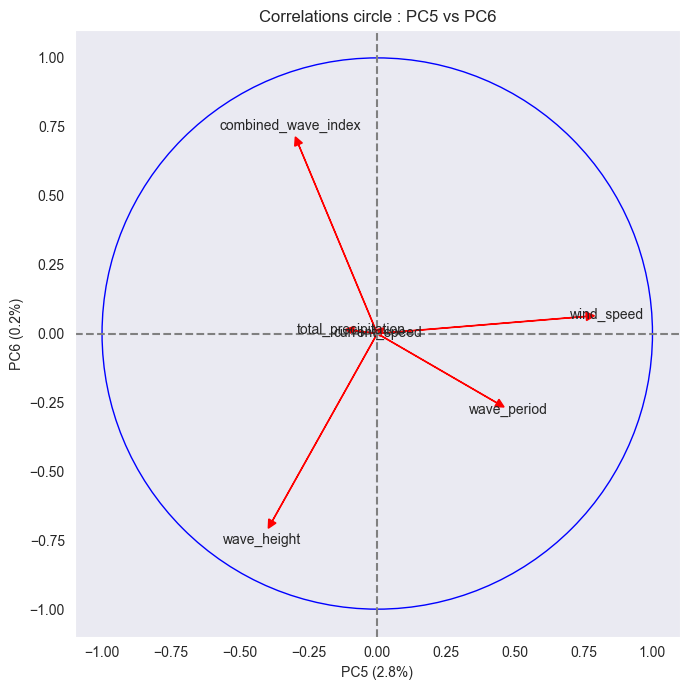

In [11]:
# Correlation circle
def plot_correlation_circle(pca, features, pc1=1, pc2=2):
    pcs = pca.components_
    explained = pca.explained_variance_ratio_ * 100

    fig, ax = plt.subplots(figsize=(7,7))
    for i, (x, y) in enumerate(zip(pcs[pc1 - 1], pcs[pc2 - 1])):
        ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='red', ec='red')
        ax.text(x*1.1, y * 1.1, features[i], ha='center', va='center')

    # Circle
    circle = plt.Circle((0, 0), 1, color='b', fill=False)
    ax.add_patch(circle)

    # Axes
    ax.axhline(0, linestyle='--', color='grey')
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    # Dynamic labels
    ax.set_xlabel(f"PC{pc1} ({explained[pc1-1]:.1f}%)")
    ax.set_ylabel(f"PC{pc2} ({explained[pc2-1]:.1f}%)")
    ax.set_title(f"Correlations circle : PC{pc1} vs PC{pc2}")

    plt.grid()
    plt.tight_layout()
    plt.show()



plot_correlation_circle(pca, X.columns, pc1=1, pc2=2)
plot_correlation_circle(pca, X.columns, pc1=3, pc2=4)
plot_correlation_circle(pca, X.columns, pc1=5, pc2=6)

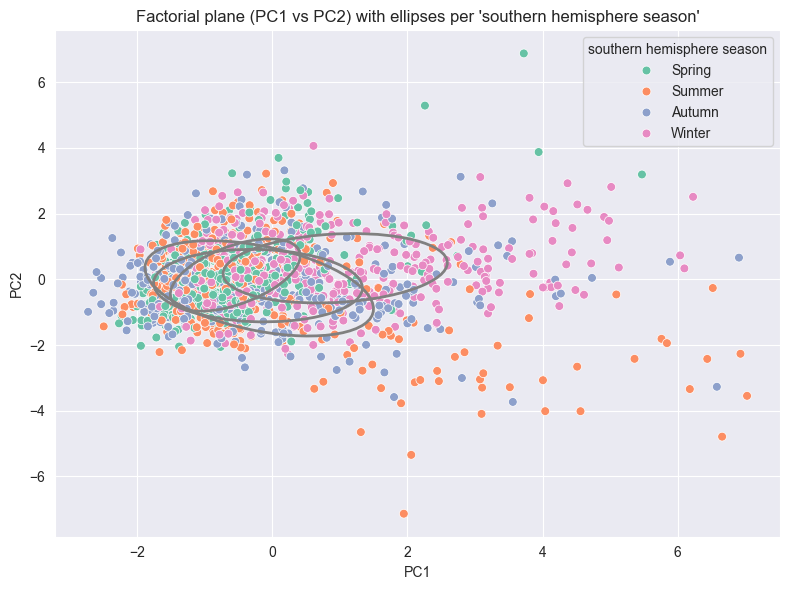

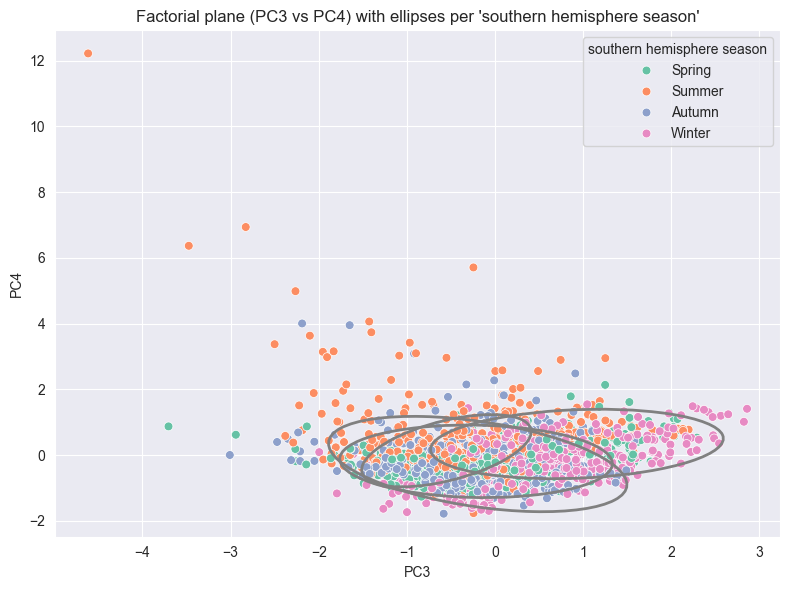

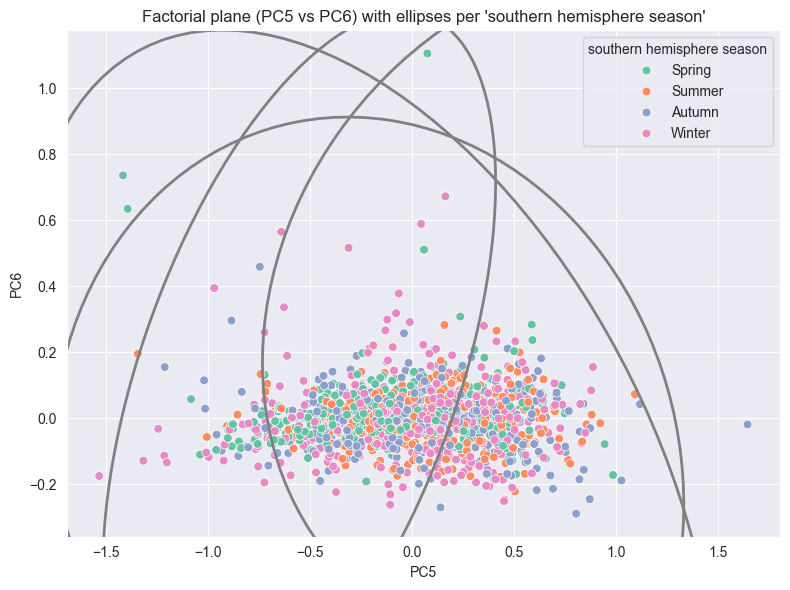

In [12]:
# # Representation in the factorial plane with ellipses
#
# # Add target
# pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range (X_pca.shape[1])], index=X.index)
# pca_df["southern hemisphere season"] = y
#
# # Draw ellipses per group
# def plot_pca_ellipses(data, hue_col, pcx="PC1", pcy="PC2", explained=None):
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(data=data, x=pcx, y=pcy, hue=hue_col, palette="Set2", s=40)
#
#     for group in data[hue_col].unique():
#         subset = data[data[hue_col] == group]
#         cov = np.cov(subset[["PC1", "PC2"]].values.T)
#         mean = subset[["PC1", "PC2"]].mean().values
#         vals, vecs = np.linalg.eigh(cov)
#         order = vals.argsort()[::-1]
#         vals, vecs = vals[order], vecs[:, order]
#         theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
#         width, height = 2 * np.sqrt(vals)
#         ell = Ellipse(xy = mean, width=width, height=height, angle=theta, edgecolor='gray', fc='None', lw=2)
#         plt.gca().add_patch(ell)
#
#
#     pcx_idx = int(pcx[2:]) - 1
#     pcy_idx = int(pcy[2:]) - 1
#     xlabel = f"{pcx} ({explained[pcx_idx]:.1f}%)" if explained is None else pcx
#     ylabel = f"{pcy} ({explained[pcx_idx]:.1f}%)" if explained is None else pcy
#
#     plt.title(f"Factorial plane ({pcx} vs {pcy}) with ellipses per '{hue_col}'")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
#
# plot_pca_ellipses(pca_df, hue_col="southern hemisphere season", pcx="PC1", pcy="PC2", explained=explained)
# plot_pca_ellipses(pca_df, hue_col="southern hemisphere season", pcx="PC3", pcy="PC4", explained=explained)
# plot_pca_ellipses(pca_df, hue_col="southern hemisphere season", pcx="PC5", pcy="PC6", explained=explained)